<a href="https://colab.research.google.com/github/rahiakela/advanced-deep-learning-with-tensorflow-2-and-keras/blob/3-autoencoders/automatic_image_colorization_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic image colorization using autoencoder

We're going to imagine that we have a grayscale photo and that we want to
build a tool that will automatically add color to it. We would like to replicate the human abilities in identifying that the sea and sky are blue, the grass field and trees are green, while the clouds are white, and so on.

<img src='https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/images/gray_color_mayon.png?raw=1' width='800'/>

As shown, if we are given a grayscale photo (left) of a rice field in
the foreground, a volcano in the background, and sky on the top, we're able to add the appropriate colors (right).

A simple automatic colorization algorithm seems like a suitable problem for
autoencoders. If we can train the autoencoder with a sufficient number of grayscale photos as input and the corresponding colored photos as output, it could possibly discover the hidden structure on properly applying colors. Roughly, it is the reverse process of denoising. The question is, can an autoencoder add color (good noise) to the original grayscale image?

## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import cifar10

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Convert RGB image to Grayscal

Firstly, we need a dataset of grayscale to colored photos. The CIFAR10 database, has 50,000 training and 10,000 testing 32 × 32 RGB photos that can be converted to grayscale.

In [0]:
def rgb2gray(rgb):
  """
  Convert from color image (RGB) to grayscale.
  grayscale = 0.299*red + 0.587*green + 0.114*blue
  Argument:
    rgb (tensor): rgb image
  Return:
    (tensor): grayscale image
  """
  return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [5]:
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train.shape

170500096/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

In [6]:
# input image dimensions, we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols  = x_train.shape[2]
channels = x_train.shape[3] 

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
save_dir

'/content/saved_images'

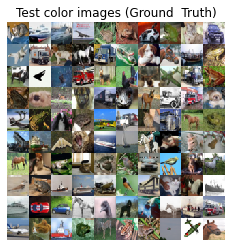

In [9]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [0]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

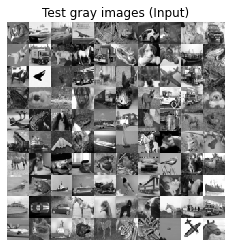

In [12]:
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

## Image preprocessing

In [0]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#  normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape color images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape grayscale images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

## Colorization autoencoder network

The colorization autoencoder network is a modified version of the denoising autoencoder.